In [17]:
# General Libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, RandomUnderSampler,
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

# Model deployment
from flask import Flask
import streamlit as st

In [3]:
data = pd.read_csv('../data/2021/2021_brfss_new_ohe.csv')
data

,target,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220406,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
220407,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
220408,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
220409,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220411 entries, 0 to 220410
Data columns (total 64 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   target                                                220411 non-null  float64
 1   HighBP                                                220411 non-null  float64
 2   HighChol                                              220411 non-null  float64
 3   CholCheck                                             220411 non-null  float64
 4   Smoker                                                220411 non-null  float64
 5   Stroke                                                220411 non-null  float64
 6   PhysActivity                                          220411 non-null  float64
 7   Fruits                                                220411 non-null  float64
 8   Veggies                                     

Would Recommend:          0
0.0  200163
1.0   20248
Proportion Chance Criterion: 83.31%
1.25 * Proportion Chance Criterion: 104.14%


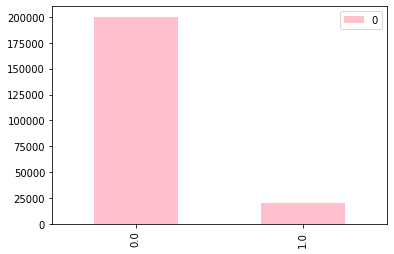

In [5]:
state_counts = Counter(data['target'])
data_state = pd.DataFrame.from_dict(state_counts, orient='index')
data_state.plot(kind='bar', color='pink')

num=(data_state[0]/data_state[0].sum())**2

print("Would Recommend:{}".format(data_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [6]:
X = data.drop(['target'], axis=1)
y = data['target']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=69, test_size=0.20,
                                                                  stratify=y)

In [7]:
def train_lr(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"logisticregression__C":  [1e-3,0.05, 0.1],
              "logisticregression__solver": ['liblinear','newton-cg','sag','lbfgs'],
              "logisticregression__max_iter":[100,1000]
              
             }

    if resample is True:
        imba_pipeline = make_pipeline(res_t,LogisticRegression(random_state=143))
    else:
        imba_pipeline = make_pipeline(LogisticRegression(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=params,
                            return_train_score=True,
                            verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Logistic Regression Clasiffier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric,
                                   return_train_score=True)

        return ['Logistic Regression Clasiffier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [18]:
start_time = time.time()
lr_tk_rec_nm = train_lr(X_trainval, y_trainval, ['recall','accuracy'], RandomUnderSampler(),
                       hypertune=True, resample=True)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear
[CV 1/5; 1/24] END logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear;, score=(train=0.739, test=0.738) total time=   0.1s
[CV 2/5; 1/24] START logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear
[CV 2/5; 1/24] END logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear;, score=(train=0.736, test=0.734) total time=   0.1s
[CV 3/5; 1/24] START logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear
[CV 3/5; 1/24] END logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__solver=liblinear;, score=(train=0.736, test=0.740) total time=   0.1s
[CV 4/5; 1/24] START logisticregression__C=0.001, logisticr

[CV 4/5; 6/24] END logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=newton-cg;, score=(train=0.743, test=0.744) total time=   0.3s
[CV 5/5; 6/24] START logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=newton-cg
[CV 5/5; 6/24] END logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=newton-cg;, score=(train=0.745, test=0.739) total time=   0.3s
[CV 1/5; 7/24] START logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=sag
[CV 1/5; 7/24] END logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=sag;, score=(train=0.745, test=0.744) total time=   0.4s
[CV 2/5; 7/24] START logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=sag
[CV 2/5; 7/24] END logisticregression__C=0.001, logisticregression__max_iter=1000, logisticregression__solver=sag;, score=(train=0.74

[CV 3/5; 12/24] END logisticregression__C=0.05, logisticregression__max_iter=100, logisticregression__solver=lbfgs;, score=(train=0.743, test=0.744) total time=   0.3s
[CV 4/5; 12/24] START logisticregression__C=0.05, logisticregression__max_iter=100, logisticregression__solver=lbfgs
[CV 4/5; 12/24] END logisticregression__C=0.05, logisticregression__max_iter=100, logisticregression__solver=lbfgs;, score=(train=0.741, test=0.743) total time=   0.4s
[CV 5/5; 12/24] START logisticregression__C=0.05, logisticregression__max_iter=100, logisticregression__solver=lbfgs
[CV 5/5; 12/24] END logisticregression__C=0.05, logisticregression__max_iter=100, logisticregression__solver=lbfgs;, score=(train=0.743, test=0.741) total time=   0.4s
[CV 1/5; 13/24] START logisticregression__C=0.05, logisticregression__max_iter=1000, logisticregression__solver=liblinear
[CV 1/5; 13/24] END logisticregression__C=0.05, logisticregression__max_iter=1000, logisticregression__solver=liblinear;, score=(train=0.741

[CV 2/5; 18/24] END logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg;, score=(train=0.740, test=0.743) total time=   0.7s
[CV 3/5; 18/24] START logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg
[CV 3/5; 18/24] END logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg;, score=(train=0.740, test=0.742) total time=   0.9s
[CV 4/5; 18/24] START logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg
[CV 4/5; 18/24] END logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg;, score=(train=0.739, test=0.742) total time=   0.7s
[CV 5/5; 18/24] START logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg
[CV 5/5; 18/24] END logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__solver=newton-cg;, score=(

[CV 1/5; 24/24] END logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs;, score=(train=0.742, test=0.736) total time=   0.8s
[CV 2/5; 24/24] START logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs
[CV 2/5; 24/24] END logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs;, score=(train=0.741, test=0.743) total time=   1.1s
[CV 3/5; 24/24] START logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs
[CV 3/5; 24/24] END logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs;, score=(train=0.739, test=0.742) total time=   1.1s
[CV 4/5; 24/24] START logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs
[CV 4/5; 24/24] END logisticregression__C=0.1, logisticregression__max_iter=1000, logisticregression__solver=lbfgs;, score=(train=0.740, test=0.7

In [19]:
lr_tk_rec_nm

['Logistic Regression Clasiffier',
 0.7411213040924615,
 0.742581973726502,
 "Best parameters = {'logisticregression__C': 0.001, 'logisticregression__max_iter': 1000, 'logisticregression__solver': 'lbfgs'}",
 122.38868117332458,
 Pipeline(steps=[('randomundersampler', RandomUnderSampler()),
                 ('logisticregression',
                  LogisticRegression(C=0.001, max_iter=1000, random_state=143))])]

In [10]:
lr_tk_acc_nm

['Logistic Regression Clasiffier',
 0.4365856867172802,
 0.49967675179884424,
 "Best parameters = {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'liblinear'}",
 494.1872363090515,
 Pipeline(steps=[('nearmiss', NearMiss()),
                 ('logisticregression',
                  LogisticRegression(C=0.001, random_state=143,
                                     solver='liblinear'))])]

In [11]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [lr_tk_rec_nm[0],
                np.round(lr_tk_acc_nm[1]*100, 6),
                np.round(lr_tk_acc_nm[2]*100, 6),
                np.round(lr_tk_rec_nm[1]*100, 6),
                np.round(lr_tk_rec_nm[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)



SyntaxError: invalid syntax (<ipython-input-11-67ff1cec1053>, line 6)

In [20]:
# re-fitting for the holdout
rh = lr_tk_rec_nm[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [24]:
# cross-validation
base_var = train_lr(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [25]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(lr_tk_rec_nm[1]*100, 2)),
                 '{:.2f}%'.format(np.round(lr_tk_rec_nm[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,10.30%,10.13%,9.33%
Resampling x Hypertune,74.11%,74.26%,74.86%


# try different sampling


In [27]:
start_time = time.time()
lr_tk_smoten = train_lr(X_trainval, y_trainval, ['recall','accuracy'], Smoten(),
                       hypertune=True, resample=True)

NameError: name 'Smoten' is not defined

In [28]:
lr_tk_rec_allknn

['Logistic Regression Clasiffier',
 0.9097920490736465,
 0.9098554862649302,
 "Best parameters = {'logisticregression__C': 0.05, 'logisticregression__max_iter': 1000, 'logisticregression__solver': 'lbfgs'}",
 2062.100564479828,
 Pipeline(steps=[('logisticregression',
                  LogisticRegression(C=0.05, max_iter=1000, random_state=143))])]

In [29]:
lr_tk_acc_allknn

['Logistic Regression Clasiffier',
 0.9097920490736465,
 0.9098554862649302,
 "Best parameters = {'logisticregression__C': 0.05, 'logisticregression__max_iter': 1000, 'logisticregression__solver': 'lbfgs'}",
 1990.823035478592,
 Pipeline(steps=[('logisticregression',
                  LogisticRegression(C=0.05, max_iter=1000, random_state=143))])]

In [31]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [lr_tk_rec_allknn[0],
                np.round(lr_tk_acc_allknn[1]*100, 6),
                np.round(lr_tk_acc_allknn[2]*100, 6),
                np.round(lr_tk_rec_allknn[1]*100, 6),
                np.round(lr_tk_rec_allknn[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [lr_tk_rec_allknn[0],
                 '{:.2f}%'.format(np.round(lr_tk_acc_allknn[1]*100, 2)),
                 '{:.2f}%'.format(np.round(lr_tk_acc_allknn[2]*100, 2)),
                 '{:.2f}%'.format(np.round(lr_tk_rec_allknn[1]*100, 2)),
                 '{:.2f}%'.format(np.round(lr_tk_rec_allknn[2]*100, 2))]
hyper2.style.hide_index()


,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Logistic Regression Clasiffier,90.98%,90.99%,90.98%,90.99%


In [32]:
# re-fitting for the holdout
rh = lr_tk_rec_allknn[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [89]:
# cross-validation
base_var = train_gb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [90]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(lr_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(lr_tk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,10.30%,10.13%,9.33%
Resampling x Hypertune,90.98%,90.99%,9.31%
